In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts,GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV,LinearRegression,BayesianRidge,Ridge, LogisticRegression
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor as KNNR
import scipy
import plotly.plotly as py
import plotly.graph_objs as go
import pygsheets

%matplotlib inline
pd.options.display.max_rows=100
pd.options.display.max_columns=100

- Ideas
    - Bring back data
    - try cleaning it more thoroughly
    - try creating a few more interesting features (look at their distributions!!)
    - Try an MCMC or another approach
    - try PCA then a regression
- Timeline
    - do more extensive data cleaning during the week
    - convert models to DAG

In [195]:
gc = pygsheets.authorize(outh_file='/Users/irarickman/client_secret.json')
file = 'Activity data'
sh = gc.open(file)

wks_1 = sh[0]
strava=wks_1.get_as_df(empty_value=np.nan)
strava.dropna(how='all',inplace=True)

wks_2=sh[1]
whoop=wks_2.get_as_df(empty_value=np.nan)
whoop.dropna(how='all',inplace=True)
whoop.dropna(axis=1,how='all',inplace=True)

wks_3=sh[2]
acts=wks_3.get_as_df(empty_value=np.nan)
acts.dropna(how='all',inplace=True)
acts.dropna(axis=1,how='all',inplace=True)


In [196]:
print(strava.shape)
strava.columns

(277, 44)


Index(['achievement_count', 'athlete_count', 'average_speed', 'average_watts',
       'comment_count', 'commute', 'device_watts', 'distance', 'elapsed_time',
       'elev_high', 'elev_low', 'external_id', 'flagged', 'gear_id',
       'has_kudoed', 'id', 'kilojoules', 'kudos_count', 'manual', 'max_speed',
       'max_watts', 'moving_time', 'name', 'photo_count', 'private',
       'start_date', 'start_date_local', 'timezone', 'total_elevation_gain',
       'total_photo_count', 'trainer', 'type', 'upload_id',
       'weighted_average_watts', 'workout_type', 'miles', 'race',
       'date_string', 'moving_minutes', 'elapsed_minutes', 'rest', 'avg_mph',
       'time_since_last_act', 'order'],
      dtype='object')

In [197]:
strava.type.value_counts()

Run       210
Ride       38
Swim       27
Walk        1
Rowing      1
Name: type, dtype: int64

In [198]:
strava[strava.type=='Run'].describe()

,achievement_count,athlete_count,average_speed,average_watts,comment_count,distance,elapsed_time,elev_high,elev_low,gear_id,id,kilojoules,kudos_count,max_speed,max_watts,moving_time,photo_count,total_elevation_gain,total_photo_count,upload_id,weighted_average_watts,workout_type,miles,race,moving_minutes,elapsed_minutes,rest,avg_mph,time_since_last_act,order
count,210.000000,210.000000,210.000000,0.0,210.000000,210.000000,210.000000,210.000000,210.000000,0.0,2.100000e+02,0.0,210.000000,210.000000,0.0,210.000000,210.0,210.000000,210.000000,2.100000e+02,0.0,13.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,209.000000,210.000000
mean,1.185714,3.576190,3.162552,NaN,0.033333,9038.706667,3271.095238,103.239048,67.200952,NaN,1.996757e+09,NaN,3.504762,6.540000,NaN,2864.228571,0.0,76.200000,0.023810,2.133686e+09,NaN,0.692308,5.616390,0.042857,47.737143,54.518254,6.781111,7.074630,-40.631579,1.085714
std,2.429639,17.185907,0.361231,NaN,0.226969,4075.227032,1409.715041,180.723561,137.099752,NaN,2.644374e+08,NaN,2.605198,2.436568,NaN,1295.345763,0.0,76.126739,0.228171,2.748928e+08,NaN,0.480384,2.532228,0.203019,21.589096,23.495251,8.396963,0.808074,23.567480,0.297173
min,0.000000,1.000000,0.802000,NaN,0.000000,1705.200000,786.000000,-100.200000,-246.800000,NaN,1.483968e+09,NaN,0.000000,3.400000,NaN,439.000000,0.0,8.000000,0.000000,1.598846e+09,NaN,0.000000,1.059562,0.000000,7.316667,13.100000,0.000000,1.794074,-171.000000,1.000000
25%,0.000000,1.000000,3.041000,NaN,0.000000,5978.075000,2226.000000,60.000000,19.650000,NaN,1.782659e+09,NaN,2.000000,4.825000,NaN,1966.500000,0.0,40.000000,0.000000,1.913243e+09,NaN,0.000000,3.714602,0.000000,32.775000,37.100000,2.208333,6.802717,-52.000000,1.000000
50%,0.000000,1.000000,3.177500,NaN,0.000000,8648.800000,3064.500000,67.700000,46.200000,NaN,2.038640e+09,NaN,3.000000,5.900000,NaN,2724.500000,0.0,56.000000,0.000000,2.178394e+09,NaN,1.000000,5.374114,0.000000,45.408333,51.075000,3.608333,7.108068,-37.000000,1.000000
75%,1.000000,1.000000,3.320250,NaN,0.000000,10808.325000,4089.000000,89.000000,54.800000,NaN,2.217233e+09,NaN,5.000000,7.500000,NaN,3556.000000,0.0,81.000000,0.000000,2.361745e+09,NaN,1.000000,6.715980,0.000000,59.266667,68.150000,6.779167,7.427399,-25.000000,1.000000
max,13.000000,179.000000,4.304000,NaN,2.000000,22539.300000,8744.000000,1998.400000,1418.800000,NaN,2.396555e+09,NaN,17.000000,17.400000,NaN,7364.000000,0.0,611.000000,3.000000,2.548216e+09,NaN,1.000000,14.005267,1.000000,122.733333,145.733333,43.100000,9.628048,-1.000000,3.000000


In [199]:
## since there are some times where i accidentally stored a run as two separate activities, 
## trying to find them to see if it's worth it to join them
strava['multi_act']=strava.groupby('date_string').id.transform(len)>1
strava['multi_run']=strava.groupby(['date_string','type']).id.transform(len)>1
multi_runs=strava[(strava.multi_run)&(strava.type=='Run')]
multi_runs['start_date_time']=pd.to_datetime(multi_runs.start_date_local)
# multi_runs['end_time']=multi_runs.start_date_local+multi_runs.elapsed_time/60.0
# multi_runs.end_time
multi_runs['end_time']=multi_runs.start_date_time + pd.to_timedelta(multi_runs.elapsed_time,unit='s')
multi_runs[['start_date_local','end_time']]

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,start_date_local,end_time
73,2018-07-15 06:50:01+00:00,2018-07-15 07:36:18
75,2018-07-15 08:57:52+00:00,2018-07-15 09:50:52
132,2018-10-03 06:27:25+00:00,2018-10-03 07:00:13
133,2018-10-03 07:20:42+00:00,2018-10-03 07:45:46
176,2019-01-05 12:38:09+00:00,2019-01-05 13:34:22
177,2019-01-05 13:40:22+00:00,2019-01-05 13:53:35
229,2019-03-24 13:06:38+00:00,2019-03-24 14:01:29
230,2019-03-24 14:10:02+00:00,2019-03-24 14:30:27
235,2019-04-01 06:25:51+00:00,2019-04-01 06:57:34
236,2019-04-01 06:58:36+00:00,2019-04-01 07:25:53


In [200]:
examine=['2019-01-05','2019-01-17','2019-01-1']
strava[strava.date_string in ]

SyntaxError: invalid syntax (<ipython-input-200-38ab8d24996b>, line 2)

In [201]:
## to simplify things, I want to delete the days with multiple activities
strava['multi_act']=strava.groupby('date_string').id.transform(len)>1
single_acts=strava[(strava.multi_act==False)&(strava.type=='Run')]
len(single_acts)

187

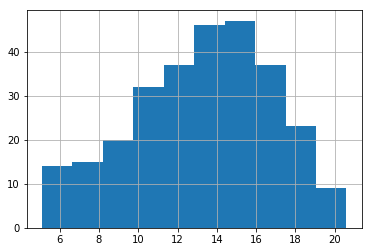

In [202]:
acts.score.hist()

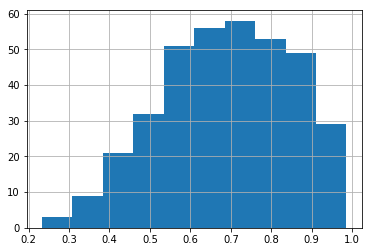

In [203]:
## looking at distribution of strain scores for days
whoop.strain.apply(lambda x: np.nan if x=='---' else x/21.0).astype(float).hist()

In [204]:
## need to fix some of the nulls in the activity data, by regenerating it with the whoop data
whoop.head()
whoop.isnull().sum()

strain              0
recovery            0
sleep_perf          6
sleep               6
rec_sleep           0
date                0
date_string         0
activity_1          0
activity_1_score    0
activity_2          0
activity_2_score    0
activity_3          0
activity_3_score    0
dtype: int64

In [205]:
## figuring out what to do with these
whoop[(whoop.recovery=='---')|(whoop.sleep=='---')|(whoop.rec_sleep=='---')|whoop.recovery.isnull()|whoop.sleep.isnull()]


,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score
45,4.9,---,---%,---,---,"Wed, Apr 10th",4/10/2019,null,null,null,null,null,null
60,10.6,Pending,NaN,NaN,0:00,"Tue, Mar 26th",3/26/2019,null,null,null,null,null,null
151,13.6,Pending,NaN,NaN,0:00,"Tue, Dec 25th",12/25/2018,Running,11.2,null,null,null,null
179,12.0,38%,NaN,NaN,8:44,"Tue, Nov 27th",11/27/2018,null,null,null,null,null,null
282,13.9,Incomplete\n Data,NaN,NaN,9:37,"Thu, Aug 16th",8/16/2018,Running,10.5,null,null,null,null
290,8.4,Incomplete\n Data,NaN,NaN,9:55,"Wed, Aug 8th",8/8/2018,null,null,null,null,null,null
350,15.7,Incomplete\n Data,NaN,NaN,10:11,"Sat, Jun 9th",6/9/2018,Swimming,13.1,null,null,null,null


In [206]:
## for recovery, I think i want to take the average or the rolling previous 3 day average
testing=whoop.copy(deep=True)
testing['rec']=testing['recovery'].astype(str).apply(lambda x: np.nan if '%' not in x else float(x[:len(x)-1])/100)
testing['rec'].mean() ## avg is .53
testing['missing_rec_p3']=testing.sort_values('date_string')['rec'].shift(1).rolling(3).mean()
testing[testing.rec.isnull()].missing_rec_p3.mean() ## average of rolling previous 3 is .5106 (seems fair)


0.5105555555555555

In [207]:
def time_to_dec(t):
    if ":" in t:
        hr=float(t[:t.find(':')])
        m=float(t[t.find(':')+1:])/60
        return hr+m
    else:
        return np.nan

In [208]:
## for sleep, I think i want to do the average recommended sleep gap (when present, otherwise I'll do avg sleep for a tuesday)
testing.sleep=testing.sleep.astype(str).apply(time_to_dec)
testing.rec_sleep=testing.rec_sleep.astype(str).apply(lambda x: time_to_dec(x) if x!=0 else x)
testing['sleep_perf']=testing['sleep_perf'].astype(str).apply(lambda x: np.nan if '-' in x or "na" in x else float(x[:len(x)-1])/100)
testing.rec_sleep.mean(),testing.sleep_perf.mean() ## so sleep needs to be .717 * rec sleep if present

(9.340925925925927, 0.7178248587570621)

In [216]:
## avg sleep for a tuesday and wednesday
testing[testing['date'].str.contains('Tue')].sleep.mean(),testing[testing['date'].str.contains('Wed')].sleep.mean()

(6.773611111111112, 6.453666666666667)

In [211]:
whoop['rec']=whoop['recovery'].astype(str).apply(lambda x: np.nan if '%' not in x else float(x[:len(x)-1])/100)
whoop['missing_rec_p3']=whoop.sort_values('date_string')['rec'].shift(1).rolling(3).mean()
whoop['fixed_recovery']=whoop.apply(lambda x: x.rec if ~np.isnan(x.rec) else x.missing_rec_p3,axis=1)
whoop[whoop.fixed_recovery.isnull()]

,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score,rec,missing_rec_p3,fixed_recovery


In [217]:
whoop['fixed_sleep']=whoop.sleep.astype(str).apply(time_to_dec)
whoop['fixed_rec_sleep']=whoop.rec_sleep.astype(str).apply(lambda x: time_to_dec(x) if x!=0 else x)
whoop['fixed_sleep_perf']=whoop['sleep_perf'].astype(str).apply(lambda x: np.nan if '-' in x or "na" in x else float(x[:len(x)-1])/100)
whoop['fixed_sleep2']=whoop.apply(lambda x: x.fixed_sleep if ~np.isnan(x.fixed_sleep) else (6.77 if 'Tue' in x['date'] else (6.45 if 'Wed' in x['date'] else .717*x.fixed_rec_sleep)),axis=1)
whoop[whoop['fixed_sleep2'].isnull()]
            

,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score,rec,missing_rec_p3,fixed_recovery,fixed_sleep,fixed_rec_sleep,fixed_sleep_perf,fixed_sleep2


In [229]:
all_whoop=whoop.drop(['rec','recovery','sleep','sleep_perf','fixed_sleep','missing_rec_p3','rec_sleep'],axis=1)
all_whoop.head()
rnm={x:x.replace("fixed_",'') if x!='fixed_sleep2' else 'sleep' for x in all_whoop.columns if 'fixed' in x}

all_whoop.rename(columns=rnm,inplace=True)

In [231]:
all_whoop['rec_color']=all_whoop.recovery.apply(lambda x: 'red' if x<.34 else ('yellow' if x<.67 else ('none' if np.isnan(x) else 'green') ))
all_whoop.strain=all_whoop.strain.apply(lambda x: float(x) if x!="---" else 0)
all_whoop['sleep_addition']=all_whoop.rec_sleep-7.75
all_whoop['pday_rec']=all_whoop['recovery'].shift(-1)
all_whoop['pday_rec_col']=all_whoop['rec_color'].shift(-1)
for n in range(1,4):
    act_num="activity_{}_score".format(n)
    all_whoop[act_num]=all_whoop[act_num].apply(lambda x: np.nan if x=='null' else x)
all_whoop['activity_total']=all_whoop[['activity_1_score','activity_2_score','activity_3_score']].apply(lambda x: sum([0 if y=='null' else (0 if np.isnan(y) else 1) for y in x ]),axis=1 )
all_whoop['pday_acts']=all_whoop['activity_total'].shift(-1)
all_whoop['pday_strain']=all_whoop['strain'].shift(-1)
all_whoop['pday_sleep']=all_whoop.sleep.shift(-1)
all_whoop['pday_sleep_perf']=all_whoop.sleep_perf.shift(-1)
all_whoop['rolling_prev_2']=all_whoop.pday_sleep.rolling(2).mean()
all_whoop['prev_strain_rec_gap']=all_whoop.pday_strain/all_whoop.pday_strain.max()-all_whoop.pday_rec

act_1=all_whoop[['date','activity_1','activity_1_score']]
act_1.columns=['date','activity','score']
act_1['order']=1

act_2=all_whoop[['date','activity_2','activity_2_score']]
act_2.columns=['date','activity','score']
act_2['order']=2
act_2.dropna(inplace=True)

act_3=all_whoop[['date','activity_3','activity_3_score']]
act_3.columns=['date','activity','score']
act_3['order']=3
act_3.dropna(inplace=True)

full_whoop=pd.concat([act_1,act_2,act_3])
full_desc=all_whoop.drop(['activity_1','activity_2','activity_3','activity_1_score','activity_2_score','activity_3_score'],
                   axis=1)
whoop_df=full_desc.merge(full_whoop, how ='left',left_on='date',right_on='date')
whoop_df.head()

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,strain,date,date_string,recovery,rec_sleep,sleep_perf,sleep,sleep_addition,pday_rec,rec_color,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,activity,score,order
0,20.1,"Today, May 25th",5/25/2019,0.53,9.883333,0.91,8.950000,2.133333,0.71,yellow,green,1,2.0,16.8,6.833333,0.73,NaN,0.101594,Running,19.8,1
1,16.8,"Fri, May 24th",5/24/2019,0.71,9.366667,0.73,6.833333,1.616667,0.51,green,yellow,2,0.0,12.0,6.750000,0.66,6.791667,0.069710,Running,13.3,1
2,16.8,"Fri, May 24th",5/24/2019,0.71,9.366667,0.73,6.833333,1.616667,0.51,green,yellow,2,0.0,12.0,6.750000,0.66,6.791667,0.069710,Activity,8.1,2
3,12.0,"Thu, May 23rd",5/23/2019,0.51,10.233333,0.66,6.750000,2.483333,0.91,yellow,green,0,1.0,19.4,5.816667,0.64,6.283333,0.027198,null,NaN,1
4,19.4,"Wed, May 22nd",5/22/2019,0.91,9.100000,0.64,5.816667,1.350000,0.68,green,green,1,0.0,12.8,8.000000,0.80,6.908333,-0.061643,Running,18.2,1


In [232]:
all_whoop

,strain,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score,recovery,rec_sleep,sleep_perf,sleep,sleep_addition,pday_rec,rec_color,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap
0,20.1,"Today, May 25th",5/25/2019,Running,19.8,null,NaN,null,NaN,0.530000,9.883333,0.91,8.950000,2.133333,0.710000,yellow,green,1,2.0,16.8,6.833333,0.73,NaN,0.101594
1,16.8,"Fri, May 24th",5/24/2019,Running,13.3,Activity,8.1,null,NaN,0.710000,9.366667,0.73,6.833333,1.616667,0.510000,green,yellow,2,0.0,12.0,6.750000,0.66,6.791667,0.069710
2,12.0,"Thu, May 23rd",5/23/2019,null,NaN,null,NaN,null,NaN,0.510000,10.233333,0.66,6.750000,2.483333,0.910000,yellow,green,0,1.0,19.4,5.816667,0.64,6.283333,0.027198
3,19.4,"Wed, May 22nd",5/22/2019,Running,18.2,null,NaN,null,NaN,0.910000,9.100000,0.64,5.816667,1.350000,0.680000,green,green,1,0.0,12.8,8.000000,0.80,6.908333,-0.061643
4,12.8,"Tue, May 21st",5/21/2019,null,NaN,null,NaN,null,NaN,0.680000,10.066667,0.80,8.000000,2.316667,0.750000,green,green,0,1.0,17.5,5.650000,0.63,6.825000,0.095411
5,17.5,"Mon, May 20th",5/20/2019,Running,15.2,null,NaN,null,NaN,0.750000,9.016667,0.63,5.650000,1.266667,0.210000,green,red,1,1.0,14.0,7.466667,0.84,6.558333,0.466329
6,14.0,"Sun, May 19th",5/19/2019,Running,10.6,null,NaN,null,NaN,0.210000,8.916667,0.84,7.466667,1.166667,0.430000,red,yellow,1,1.0,15.3,3.566667,0.39,5.516667,0.309130
7,15.3,"Sat, May 18th",5/18/2019,Cycling,8.3,null,NaN,null,NaN,0.430000,9.250000,0.39,3.566667,1.500000,0.520000,yellow,yellow,1,1.0,18.9,8.816667,0.91,6.191667,0.393043
8,18.9,"Fri, May 17th",5/17/2019,Running,17.1,null,NaN,null,NaN,0.520000,9.666667,0.91,8.816667,1.916667,0.370000,yellow,yellow,1,1.0,12.9,6.300000,0.60,7.558333,0.253188
9,12.9,"Thu, May 16th",5/16/2019,Running,10.0,null,NaN,null,NaN,0.370000,10.550000,0.60,6.300000,2.800000,0.860000,yellow,green,1,1.0,20.1,5.416667,0.58,5.858333,0.111014


In [101]:
acts.date_string=pd.to_datetime(acts.date_string)
single_acts.date_string=pd.to_datetime(single_acts.date_string)
data=acts.merge(single_acts, left_on=['date_string','order'],right_on=['date_string','order'])
data.head()

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,rec_color,sleep_addition,pday_rec,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,activity,score,order,achievement_count,athlete_count,average_speed,average_watts,comment_count,commute,device_watts,distance,elapsed_time,elev_high,elev_low,external_id,flagged,gear_id,has_kudoed,id,kilojoules,kudos_count,manual,max_speed,max_watts,moving_time,name,photo_count,private,start_date,start_date_local,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,weighted_average_watts,workout_type,miles,race,moving_minutes,elapsed_minutes,rest,avg_mph,time_since_last_act,multi_act,multi_run
0,20.1,0.53,0.91,8.950000,9.883333,"Today, May 25th",2019-05-25,yellow,2.133333,0.71,green,1.0,2.0,16.8,6.833333,0.73,NaN,0.101594,Running,19.8,1.0,0.0,1.0,3.014,NaN,0.0,FALSE,NaN,17710.5,6259.0,83.4,67.0,garmin_push_3683077636,FALSE,NaN,FALSE,2.396555e+09,NaN,2.0,FALSE,6.0,NaN,5877.0,Morning Run,0.0,FALSE,2019-05-25 10:47:46+00:00,2019-05-25 10:47:46+00:00,(GMT-05:00) America/New_York,63.0,0.0,FALSE,Run,2.548216e+09,NaN,NaN,11.004791,0.0,97.950000,104.316667,6.366667,6.742318,NaN,False,False
1,16.8,0.71,0.73,6.833333,9.366667,"Fri, May 24th",2019-05-24,green,1.616667,0.51,yellow,2.0,0.0,12.0,6.750000,0.66,6.791667,0.069710,Running,13.3,1.0,0.0,1.0,3.050,NaN,0.0,FALSE,NaN,8831.8,3089.0,66.4,46.8,garmin_push_3678973550,FALSE,NaN,FALSE,2.393119e+09,NaN,2.0,FALSE,8.0,NaN,2896.0,Morning Run,0.0,FALSE,2019-05-24 07:29:22+00:00,2019-05-24 07:29:22+00:00,(GMT-05:00) America/New_York,59.0,0.0,FALSE,Run,2.544668e+09,NaN,NaN,5.487824,0.0,48.266667,51.483333,3.216667,6.822850,-28.0,False,False
2,19.4,0.91,0.64,5.816667,9.100000,"Wed, May 22nd",2019-05-22,green,1.350000,0.68,green,1.0,0.0,12.8,8.000000,0.80,6.908333,-0.061643,Running,18.2,1.0,1.0,1.0,3.127,NaN,0.0,FALSE,NaN,16095.8,5223.0,65.8,40.8,garmin_push_3672611776,FALSE,NaN,FALSE,2.387725e+09,NaN,3.0,FALSE,8.7,NaN,5148.0,Morning Run,0.0,FALSE,2019-05-22 06:11:36+00:00,2019-05-22 06:11:36+00:00,(GMT-05:00) America/New_York,96.0,0.0,FALSE,Run,2.539116e+09,NaN,NaN,10.001463,0.0,85.800000,87.050000,1.250000,6.995099,-50.0,False,False
3,17.5,0.75,0.63,5.650000,9.016667,"Mon, May 20th",2019-05-20,green,1.266667,0.21,red,1.0,1.0,14.0,7.466667,0.84,6.558333,0.466329,Running,15.2,1.0,6.0,1.0,3.096,NaN,0.0,FALSE,NaN,14894.9,4952.0,77.0,20.4,garmin_push_3666495452,FALSE,NaN,FALSE,2.382517e+09,NaN,5.0,FALSE,6.9,NaN,4811.0,Morning Run,0.0,FALSE,2019-05-20 06:27:51+00:00,2019-05-20 06:27:51+00:00,(GMT-05:00) America/New_York,85.0,0.0,FALSE,Run,2.533785e+09,NaN,NaN,9.255259,0.0,80.183333,82.533333,2.350000,6.925752,-48.0,False,False
4,14.0,0.21,0.84,7.466667,8.916667,"Sun, May 19th",2019-05-19,red,1.166667,0.43,yellow,1.0,1.0,15.3,3.566667,0.39,5.516667,0.309130,Running,10.6,1.0,0.0,3.0,2.724,NaN,0.0,FALSE,NaN,5821.9,2922.0,46.0,13.6,garmin_push_3665044594,FALSE,NaN,FALSE,2.381357e+09,NaN,1.0,FALSE,6.6,NaN,2137.0,Morning Run,0.0,FALSE,2019-05-19 10:17:00+00:00,2019-05-19 10:17:00+00:00,(GMT-05:00) America/New_York,47.0,0.0,FALSE,Run,2.532584e+09,NaN,NaN,3.617560,0.0,35.616667,48.700000,13.083333,6.093588,-21.0,False,False


In [107]:
data.isnull().sum()

strain                      0
recovery                    3
sleep_perf                  3
sleep                       3
rec_sleep                   1
date                        0
date_string                 0
rec_color                   0
sleep_addition              1
pday_rec                    4
pday_rec_col                0
activity_total              0
pday_acts                   0
pday_strain                 0
pday_sleep                  5
pday_sleep_perf             5
rolling_prev_2              9
prev_strain_rec_gap         4
activity                    0
score                       1
order                       0
achievement_count           0
athlete_count               0
average_speed               0
average_watts             164
comment_count               0
commute                     0
device_watts              164
distance                    0
elapsed_time                0
elev_high                   0
elev_low                    0
external_id                 0
flagged   

In [106]:
## handling the nulls for recovery

data[data.recovery.isnull()]
## i think a good proxy is the average amount of sleep under the recommended, 
## when recommended is 0 or null, then the average of those


,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,rec_color,sleep_addition,pday_rec,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,activity,score,order,achievement_count,athlete_count,average_speed,average_watts,comment_count,commute,device_watts,distance,elapsed_time,elev_high,elev_low,external_id,flagged,gear_id,has_kudoed,id,kilojoules,kudos_count,manual,max_speed,max_watts,moving_time,name,photo_count,private,start_date,start_date_local,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,weighted_average_watts,workout_type,miles,race,moving_minutes,elapsed_minutes,rest,avg_mph,time_since_last_act,multi_act,multi_run
31,4.9,NaN,NaN,NaN,NaN,"Wed, Apr 10th",2019-04-10,none,NaN,0.42,yellow,0.0,1.0,15.2,6.433333,0.72,NaN,0.314300,null,NaN,1.0,0.0,4.0,3.153,NaN,0.0,FALSE,NaN,9344.1,3766.0,66.0,49.0,garmin_push_3542859655,FALSE,NaN,FALSE,2.279148e+09,NaN,6.0,FALSE,9.1,NaN,2964.0,Morning Run,0.0,FALSE,2019-04-10 05:57:22+00:00,2019-04-10 05:57:22+00:00,(GMT-05:00) America/New_York,110.0,0.0,FALSE,Run,2.426072e+09,NaN,NaN,5.806153,0.0,49.400000,62.766667,13.366667,7.053261,-38.0,False,False
98,13.6,NaN,NaN,NaN,0.000000,"Tue, Dec 25th",2018-12-25,none,-7.750000,0.69,green,1.0,1.0,17.0,7.466667,0.92,NaN,0.131256,Running,11.2,1.0,0.0,1.0,2.917,NaN,0.0,FALSE,NaN,5099.4,1764.0,57.8,24.2,garmin_push_3247306980,FALSE,NaN,FALSE,2.035503e+09,NaN,3.0,FALSE,7.3,NaN,1748.0,Afternoon Run,0.0,FALSE,2018-12-25 16:51:37+00:00,2018-12-25 16:51:37+00:00,(GMT-08:00) America/Los_Angeles,59.0,0.0,FALSE,Run,2.175101e+09,NaN,NaN,3.168619,0.0,29.133333,29.400000,0.266667,6.525329,-14.0,False,False
143,13.9,NaN,NaN,NaN,9.616667,"Thu, Aug 16th",2018-08-16,none,1.866667,0.39,yellow,1.0,1.0,13.8,7.116667,0.72,NaN,0.276667,Running,10.5,1.0,1.0,1.0,2.730,NaN,0.0,FALSE,NaN,5642.9,2450.0,57.6,29.0,garmin_push_2936837167,FALSE,NaN,FALSE,1.775853e+09,NaN,1.0,FALSE,3.6,NaN,2067.0,Morning Run,0.0,FALSE,2018-08-16 06:15:40+00:00,2018-08-16 06:15:40+00:00,(GMT-05:00) America/New_York,149.0,0.0,FALSE,Run,1.906230e+09,NaN,NaN,3.506334,0.0,34.450000,40.833333,6.383333,6.107010,-35.0,False,False


In [ ]:
data.dropna(inplace=True)
X=all_acts.drop(['strain','date','rec_color','pday_rec_col','activity_total','month','day_x','year','date_string','activity','score',
                 'order','start_date','day_y'],axis=1)
y=all_acts.score

In [102]:
## linear reg function
def linreg_infer(subset=False, x=X, targ=y):
    if subset!=False:
        x=X[subset]
    X=sm.add_constant(X)
    lr=sm.OLS(y, X)
    res=lr.fit()
    print(res.summary())

NameError: name 'X' is not defined